In [1]:
import multiprocessing as mp
from util.backtest import *
from util.factor_util import *
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
from tqdm import tqdm
import warnings
from time import sleep
import statsmodels.api as sm
import os
import seaborn as sns
import glob

plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] =False

In [2]:
INSAMPLE_END_DATE = datetime(2021,7,1)
VALID_END_DATE = datetime(2022,6,1)
SAMPLE_END_DATE = datetime(2022,8,31)

FREQ = 'D'


df = pd.read_csv('/home/frank/document/Python/Factors/data/data_1h.csv')
df['BuyerRatio'] = df['takerBuyQuoteVol']/df['quoteAssetVolume']
df['BuyerPerTrade'] = df['takerBuyQuoteVol']/df['numberOfTrades']
df['VolumePerTrade'] = df['quoteAssetVolume']/df['numberOfTrades']

df = df.drop(['Volume','numberOfTrades'],axis= 1)
print('Dataframe prepared completed')

Dataframe prepared completed


In [3]:
categories = {}
with open('/home/frank/document/Python/Factors/data/Crytpo_categories.json','r') as f:
    categories = json.loads(f.read())    
categories['all'] = df.symbol.unique()
for category in categories.keys():
    print(category,len(categories[category]))


token 113
coin 65
Ethereum 101
Solana-ecosystem 15
bnb-chain 43
Polkadot 17
defi 68
innovation 24
gaming 18
nft 33
infrastructure 16
layer1_layer2 35
pos 47
pow 20
all 225


In [4]:
col_list = ['Open','High','Low','Close','quoteAssetVolume','takerBuyQuoteVol','BuyerRatio']
df_data = {}
for col in col_list:
    df_data[col] = df.pivot(values = col,index = 'openTime',columns = 'symbol').astype(float)
    df_data[col].index = pd.to_datetime(df_data[col].index,unit = 'ms') #+ timedelta(hours=8)

print("Pivot table completed")

Pivot table completed


In [5]:
market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(7*24).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter & (volume_filter>0.5)
GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()

ret = df_data['Close'].sort_index().resample(FREQ).last().bfill().pct_change().fillna(0)


In [6]:
## Calc Data
formula_list = []
input_data_list = []

with open('/home/frank/document/Python/Factors/data/formulas/all_formula_list_20230221.csv','r') as f:
    formula_list += f.read().split('\n')

with open('/home/frank/document/Python/Factors/data/data_list/all_data_list_20230221.csv','r') as f:
    input_data_list += f.read().split('\n')

In [7]:
files = glob.glob('/home/frank/document/Python/Factors/output/hypertune_2307/*/*/*.csv')
files = [file for file in files if 'Ensamble' in file and 'nav' in file]
files[:5]

['/home/frank/document/Python/Factors/output/hypertune_2307/6911/False/6911_Ensamble_nav.csv',
 '/home/frank/document/Python/Factors/output/hypertune_2307/6911/True/6911_Ensamble_nav.csv',
 '/home/frank/document/Python/Factors/output/hypertune_2307/16074/False/16074_Ensamble_nav.csv',
 '/home/frank/document/Python/Factors/output/hypertune_2307/16074/True/16074_Ensamble_nav.csv',
 '/home/frank/document/Python/Factors/output/hypertune_2307/7811/False/7811_Ensamble_nav.csv']

In [8]:


strategies = pd.read_csv('/home/frank/document/Python/Factors/output/backtest_result/D/level1_IC_metrics2.csv').Strategy.sort_values().to_list()



In [9]:
metrics = []
navs = {}

files = glob.glob('/home/frank/document/Python/Factors/output/hypertune_2307/*/*/*.csv')
files = [file for file in files if 'Ensamble' in file and 'nav' in file]


for File in files[:]:
    strategy_id = File.split('/')[-3]
    reverse = True if File.split('/')[-2] == 'True' else False
    name = strategies[int(File.split('/')[-3])] + ('_Reverse' if File.split('/')[-2] == 'True' else '')
    # print(name)

    df = pd.read_csv(File,index_col=0)
    df.index = pd.to_datetime(df.index)
    
    navs[name] = df.copy()
    
    for ix,col in enumerate(df.columns):
        metric = show_performance_metrics(df[col],show = False)#['Ann. Sharpe']

        metric_2021 = show_performance_metrics(df[col].loc[:datetime(2022,1,1)],show = False)['Ann. Sharpe']
        metric_2022 = show_performance_metrics(df[col].loc[datetime(2022,1,1):],show = False)['Ann. Sharpe']

        metric['metric_2021'] = metric_2021
        metric['metric_2022'] = metric_2022


        metric['Name'] = name
        metric['ID'] = strategy_id
        metric['Reverse'] = reverse
        metric['Config'] = ix
        
        metrics.append(metric)
    # break

/home/frank/document/Python/Factors/util/backtest.py:191: RuntimeWarning: invalid value encountered in double_scalars
  ann_return = ann_return ** (1/(cum_profit.shape[0]/365))
/home/frank/document/Python/Factors/util/backtest.py:191: RuntimeWarning: invalid value encountered in double_scalars
  ann_return = ann_return ** (1/(cum_profit.shape[0]/365))
/home/frank/document/Python/Factors/util/backtest.py:191: RuntimeWarning: invalid value encountered in double_scalars
  ann_return = ann_return ** (1/(cum_profit.shape[0]/365))
/home/frank/document/Python/Factors/util/backtest.py:191: RuntimeWarning: invalid value encountered in double_scalars
  ann_return = ann_return ** (1/(cum_profit.shape[0]/365))
/home/frank/document/Python/Factors/util/backtest.py:191: RuntimeWarning: invalid value encountered in double_scalars
  ann_return = ann_return ** (1/(cum_profit.shape[0]/365))
/home/frank/document/Python/Factors/util/backtest.py:191: RuntimeWarning: invalid value encountered in double_scala

In [10]:
pd.DataFrame(metrics).sort_values('Ann. Sharpe')
metric = pd.DataFrame(metrics).groupby(['Name','ID','Reverse',])[['Ann. Sharpe','FitnessValue','Monthly_Return_Score','metric_2021','metric_2022']].mean()
metric['SharpeDecay'] = (metric['metric_2021'] + metric['metric_2022'])/2
metric = metric[(metric['metric_2022']>1) & (metric['metric_2021']>2)]# & (metric['Ann. Sharpe']>2)
print(metric[metric['Ann. Sharpe']>2].shape)
metric[metric['Ann. Sharpe']>2].sort_values(['Monthly_Return_Score','FitnessValue'],ascending = False).head(20)


metric = metric[(metric['metric_2022']>1) & (metric['metric_2021']>2)]# & (metric['Ann. Sharpe']>2)

# metric = metric.groupby(['Name','ID','Reverse',])[['Ann. Sharpe','FitnessValue','Monthly_Return_Score','metric_2021','metric_2022']].mean()


(27, 6)


In [11]:
metric.reset_index()['Name'].unique().shape
metric

,,,Ann. Sharpe,FitnessValue,Monthly_Return_Score,metric_2021,metric_2022,SharpeDecay
Name,ID,Reverse,,,,,,
BuyerRatio*High/Low.Skew.Pct_Change.Kurt_Reverse,1176,True,1.940587,1.169006,0.665179,2.128270,1.264694,1.696482
BuyerRatio*High/Open.Rank.Quantile75.Quantile50,2422,False,2.209463,1.393228,0.633929,2.444163,1.477112,1.960638
BuyerRatio*High/Open.Rank.Skew.Max_Reverse,2448,True,2.296101,1.419217,0.665179,2.615914,1.217381,1.916647
BuyerRatio*Open/Low.Skew.Kurt.Quantile50_Reverse,3981,True,1.841680,0.971205,0.651042,2.017836,1.246108,1.631972
BuyerRatio.Quantile75.Mean.Pct_Change,5109,False,2.070374,1.257982,0.682292,2.276822,1.448052,1.862437
BuyerRatio.Rank.Skew.Quantile25_Reverse,5305,True,2.155398,1.178646,0.651042,2.472758,1.261274,1.867016
Close.Quantile50.Rank.Rank,6479,False,2.148089,1.340839,0.660714,2.454150,1.287588,1.870869
Close.SignedPower.Pct_Change.Mean,6767,False,2.166587,1.019391,0.727679,2.585286,1.044807,1.815047
Close.Skew.Quantile75.Abs,6911,False,2.251751,1.495951,0.705357,2.412951,1.769162,2.091056


In [12]:
print(metric[metric['metric_2022']>2].shape)


(2, 6)


<AxesSubplot:xlabel='openTime'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei


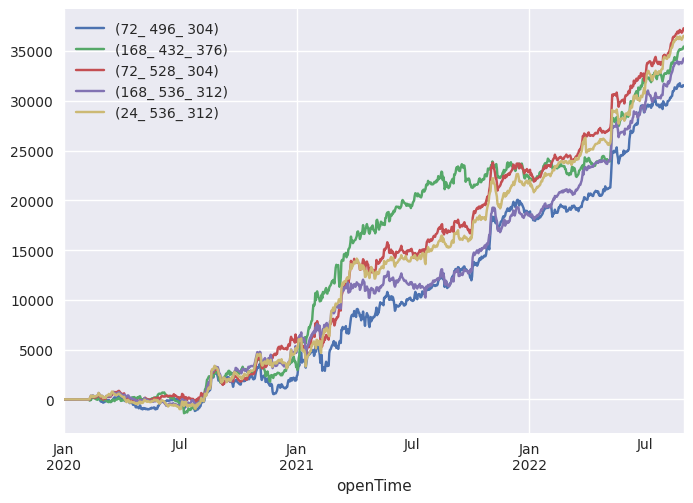

In [13]:
pd.DataFrame(metrics).Name.unique()
navs['Close/Low.SignedPower.Kurt.Skew_Reverse'].cumsum().plot()


##  Selected

In [14]:
# navs[metric]
name = metric.index[0][0]
params = navs[name].columns
params = [param.replace('(','').replace(')','').split('_') for param in params]
params = [[int(data) for data in param] for param in params]
params[0]

[336, 352, 624, 408]

In [15]:
name = metric.index[0][0]

stress_navs = {}
stress_metrics = {}


for strategy in tqdm(metric.index):
    
    name = strategy[0]

    params = navs[name].columns
    params = [param.replace('(','').replace(')','').split('_') for param in params]
    params = [[int(data) for data in param] for param in params]

    for param in params:
        vol_len = param[0]
        strategy_param = param[1:]



        category = 'all'
        subset = categories[category]
        if category != 'all':
            subset = np.unique([sym + 'usdt' for sym in subset])

        market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
        volume = df_data['quoteAssetVolume'].sort_index().rolling(vol_len).sum().fillna(0)
        volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
        GLOBAL_FILTER = market_filter & (volume_filter>0.5)
        GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()


        data = name.replace('_Reverse','').split('.')
        formula = '.'.join(data[1:])
        data = data[0]

        factor = calc_factors(calc_input_data(df_data,data),formula,params = strategy_param) #[120,128,428])#[168,72,208,528]

        factor = factor.sort_index().resample(FREQ).last()
        cond = GLOBAL_FILTER


        selected = 5



        rk = factor[cond].rank(axis = 1,ascending = '_Reverse' not in name,method = 'dense')

        select = rk.max(axis = 1) * selected * 0.01
        select = select.apply(lambda x:max(np.floor(x),3))

        long_signal = rk.copy()
        long_signal[:] = 0
        short_signal = long_signal.copy()


        long_signal[rk.gt(rk.max(axis = 1) - select,axis = 0) ] = 1 
        short_signal[rk.le(select,axis = 0) ] = -1 


        FEE = 4
        long_result = fast_backtest(ret,long_signal,fee = FEE)#.sum(axis = 1)
        short_result = fast_backtest(ret,short_signal,fee = FEE)#.sum(axis = 1)

        result = ((long_result + short_result)/2).sum(axis = 1)

        # show_return(result.loc[datetime(2020,1,1):],figsize= (12,10))

        if name in stress_navs.keys():
            stress_navs[name] += result
        else:
            stress_navs[name] = result.copy()
            
    stress_navs[name] /= len(params)
    # break



  0%|          | 0/44 [00:00<?, ?it/s]/home/frank/.local/lib/python3.10/site-packages/pandas/core/window/rolling.py:579: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
100%|██████████| 44/44 [08:46<00:00, 11.96s/it]


In [16]:
stress_metrics = pd.DataFrame(stress_navs).loc[datetime(2023,1,1):].apply(lambda x: pd.Series(show_performance_metrics(x,show = False)),axis = 0)
stress_metrics = stress_metrics.T.sort_values('Ann. Sharpe')
print(stress_metrics[stress_metrics['Ret/Mdd']>0].shape)
stress_metrics.tail(10)

(14, 8)


/home/frank/document/Python/Factors/util/backtest.py:191: RuntimeWarning: invalid value encountered in double_scalars
  ann_return = ann_return ** (1/(cum_profit.shape[0]/365))
/home/frank/document/Python/Factors/util/backtest.py:191: RuntimeWarning: invalid value encountered in double_scalars
  ann_return = ann_return ** (1/(cum_profit.shape[0]/365))
/home/frank/document/Python/Factors/util/backtest.py:191: RuntimeWarning: invalid value encountered in double_scalars
  ann_return = ann_return ** (1/(cum_profit.shape[0]/365))
/home/frank/document/Python/Factors/util/backtest.py:191: RuntimeWarning: invalid value encountered in double_scalars
  ann_return = ann_return ** (1/(cum_profit.shape[0]/365))
/home/frank/document/Python/Factors/util/backtest.py:191: RuntimeWarning: invalid value encountered in double_scalars
  ann_return = ann_return ** (1/(cum_profit.shape[0]/365))
/home/frank/document/Python/Factors/util/backtest.py:191: RuntimeWarning: invalid value encountered in double_scala

,Ann. Return(%),MDD(%),Ret/Mdd,Ann. Sharpe,ATH_Score,Monthly_Return_Score,Cummax_Score,FitnessValue
High/Open.Skew.Std.Skew_Reverse,4.440084,10.206014,0.435046,0.681223,0.104317,0.5,0.159117,0.094598
BuyerRatio*High/Low.Skew.Pct_Change.Kurt_Reverse,7.529803,6.318281,1.191749,1.420141,0.125899,0.5,0.186992,0.231756
High/Open.Kurt.SignedPower.Skew_Reverse,22.377005,16.290934,1.373586,1.426842,0.129496,0.7,0.415796,0.517764
High/Low.Pct_Change.Skew.Abs_Reverse,17.421741,13.510371,1.289509,1.463656,0.093525,0.7,0.261324,0.333806
High/Open.Skew.Pct_Change.Skew_Reverse,15.807479,11.505334,1.373926,1.572950,0.107914,0.7,0.263647,0.361921
Close/Open.Kurt.Rank_Reverse,18.148614,13.462607,1.348076,1.614797,0.169065,0.7,0.329849,0.464846
High/Close.SignedPower.Pct_Change.Kurt_Reverse,28.935381,10.695878,2.705283,1.875673,0.169065,0.9,0.475029,0.777595
BuyerRatio*High/Open.Rank.Skew.Max_Reverse,35.087373,18.817078,1.864656,2.232130,0.140288,0.7,0.385598,0.751157
High/Close.Max.Skew.Std_Reverse,23.360245,8.264465,2.826589,2.328602,0.176259,0.9,0.484321,0.984247
Close/Low.SignedPower.Kurt.Skew_Reverse,53.904667,12.883038,4.184158,2.707050,0.201439,0.8,0.500581,1.182623


<AxesSubplot:xlabel='openTime'>

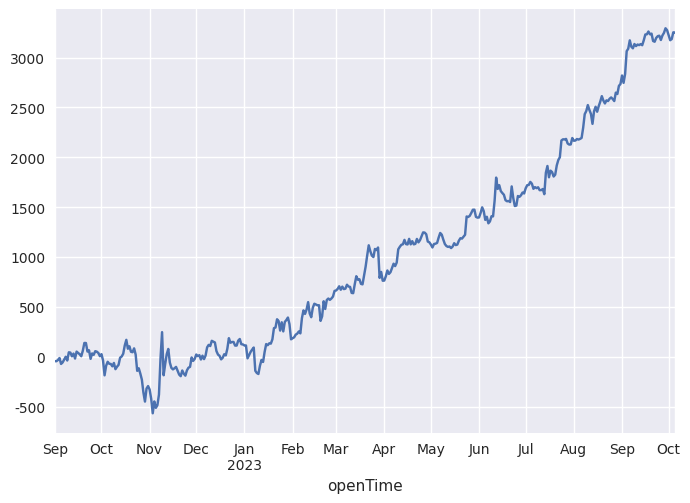

In [24]:

    
pd.DataFrame(stress_navs).cumsum()#.plot()
pd.DataFrame(stress_navs)[stress_metrics.index[-10:]].mean(axis = 1).loc[datetime(2022,9,1):].cumsum().plot()
# stress_navs.keys()
# len(params)


In [25]:
stress_nav = pd.DataFrame(stress_navs)#.mean(axis = 1).cumsum().loc[datetime(2022,9,1):]

dd = stress_nav.cumsum().cummax()- stress_nav.cumsum()
mdd = dd.loc[:datetime(2022,9,1)].max()


In [72]:
w = stress_nav.copy()
w[:] = np.nan

w[dd.rolling(90).max()>mdd] = 0
# w = w.ffill().fillna(1)
w[stress_nav.rolling(90).sum().rolling(30).min()<0] = 0
w[stress_nav.rolling(90).sum().rolling(30).min()>0] = 1

w = w.loc[datetime(2022,9,1):].ffill().fillna(1)

# w = w.rolling(30).min()

# w = 1/w
w = w.div(w.sum(axis = 1),axis = 0)


<AxesSubplot:xlabel='openTime'>

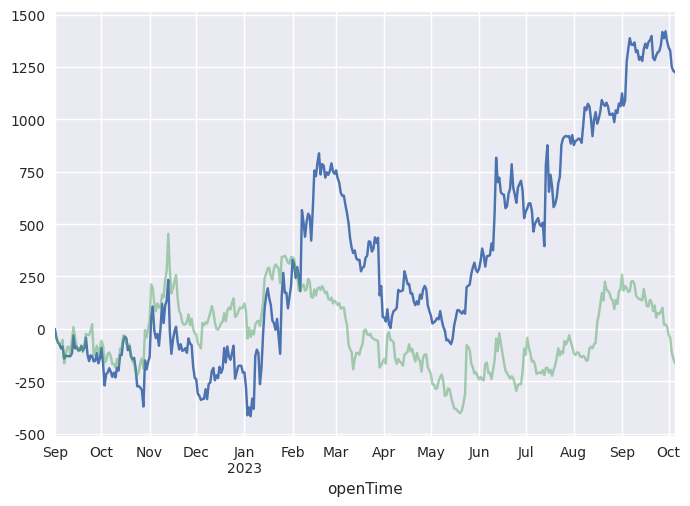

In [73]:
(w.shift(1) * stress_nav).loc[datetime(2022,9,1):].cumsum().sum(axis = 1).plot()
stress_nav.mean(axis = 1).loc[datetime(2022,9,1):].cumsum().plot(alpha = 0.5)
# w.sum(axis = 1).plot()
# (w).fillna(1).sum(axis = 1).plot()

<AxesSubplot:xlabel='openTime'>

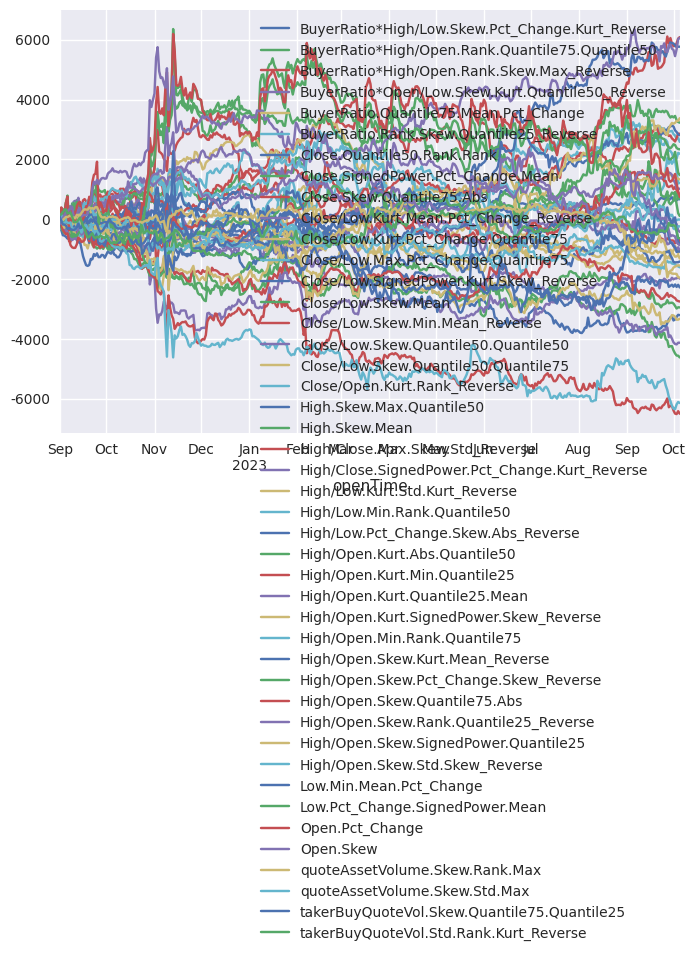

In [58]:
stress_nav.loc[datetime(2022,9,1):].cumsum().plot()